# Exploratory Data Analysis on a Natural Language Processing Task

---

Exploratory data analysis (EDA) is a crucial part of any data science project. EDA helps us discover interesting relationships in the data, detect outliers and errors, examine our own assumptions about the data, and prepare for modeling. During EDA we might discover that we need to clean our data more conscientiously, or that we have more missing data than we realized, or that there aren't many patterns in the data (indicating that modeling may be challenging.)

In this lab you'll bring in a natural language dataset and perform EDA. The dataset contains Facebook statuses taken from between 2009 and 2011 as well as personality test results associated with the users whose Facebook statuses are included.

This dataset uses results from the Big Five Personality Test, also referred to as the five-factor model, which measures a person's score on five dimensions of personality:
- **O**penness
- **C**onscientiousness
- **E**xtroversion
- **A**greeableness
- **N**euroticism

Notoriously, the political consulting group Cambridge Analytica claims to have predicted the personalities of Facebook users by using those users' data, with the goal of targeting them with political ads that would be particularly persuasive given their personality type. Cambridge Analytica claims to have considered 32 unique 'groups' in the following fashion:
- For each of the five OCEAN qualities, a user is categorized as either 'yes' or 'no'.
- This makes for 32 different potential combinations of qualities. ($2^5 = 32$).

Cambridge Analytica's methodology was then, roughly, the following:
- Gather a large amount of data from Facebook.
- Use this data to predict an individual's Big Five personality "grouping."
- Design political advertisements that would be particularly effective to that particular "grouping." (For example, are certain advertisements particularly effective toward people with specific personality traits?)

In this lab you will perform EDA to examine many relationships in the data.

Exploratory data analysis can be a non-linear process, and you're encouraged to explore questions that occur to you as you work through the notebook.

> **Content note**: This dataset contains real Facebook statuses scraped from 2009 to 2011, and some of the statuses contain language that is not safe for work, crude, or offensive. The full dataset is available as `mypersonality.csv`, and a sanitized version containing only statuses that passed an automated profanity check is available as `mypersonality_noprofanity.csv`. Please do not hesitate to use `mypersonality_noprofanity.csv` if you would prefer to. Please note that the automated profanity check is not foolproof. If you have any concerns about working with this dataset, please get in touch with your section lead.

---

### External resources

These resources are not required reading but may be of use or interest.

- [Python Graph Gallery](https://python-graph-gallery.com/)
- [Wikipedia page](https://en.wikipedia.org/wiki/Big_Five_personality_traits) on the Big Five test
- [A short (3-4 pages) academic paper](./celli-al_wcpr13.pdf) using the `MyPersonality` dataset to model personality

---

## Load packages

In [388]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import missingno
import statsmodels.api as sm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

from sklearn.feature_extraction.text import CountVectorizer

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 400

---

## Load data

In [262]:
df = pd.read_csv('data/mypersonality.csv')
df = pd.read_csv('data/mypersonality_noprofanity.csv') # comment out above & uncomment this to use mypersonality_noprofanity.csv
df.drop(columns=['NETWORKSIZE', 'BETWEENNESS', 'NBETWEENNESS', 'DENSITY', 'BROKERAGE', 'NBROKERAGE', 'TRANSITIVITY'], inplace=True)
df.head(3)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM


---

## EDA on Statuses

Before we even vectorize the text, we might look at the lengths and word counts in each Facebook status.

#### Create a new column called `status_length` that contains the length of each status:

In [263]:
df['status_length']  = df['STATUS'].str.len()

In [264]:
df.head(2)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,27
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,63


#### Create a new column called `status_word_count` that contains the number of words in each status:

Note: You can evaluate this based off of how many strings are separated by whitespaces; you're not required to check that each set of characters set apart by whitespaces is a word in the dictionary.

In [265]:
# Partially ideas taken from (https://stackoverflow.com/questions/49984905)
df['status_word_count'] = [len(x.split()) for x in df['STATUS'].tolist()]

In [266]:
df.head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length,status_word_count
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,27,5
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,63,13
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM,121,26
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/22/09 04:48 AM,42,9
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/20/09 02:31 AM,11,3


### Longest and shortest statuses

Looking at individual observations can help us get a sense of what the dataset contains.

#### Show the five longest and five shortest statuses based off of `status_word_count`:

In [267]:
# Longest five words in status_word_count
df["status_word_count"].sort_values(ascending=True).head()


1957    1
7565    1
7573    1
9090    1
3696    1
Name: status_word_count, dtype: int64

In [268]:
# Five shortest  words in status_word_count
df["status_word_count"].sort_values(ascending=False).head()


468     89
4997    84
5457    83
9301    83
9259    82
Name: status_word_count, dtype: int64

## What's the distribution of post lengths?

Use visuals to show the distributions of post lengths. Show both the distribution of word counts and the distribution of lengths based off character.

<AxesSubplot:>

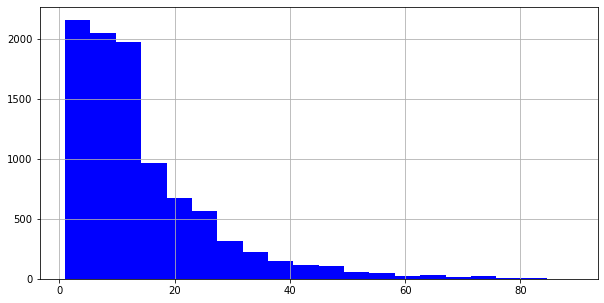

In [269]:
df['status_word_count'].hist(bins=20, color='blue', figsize=[10,5])

<AxesSubplot:>

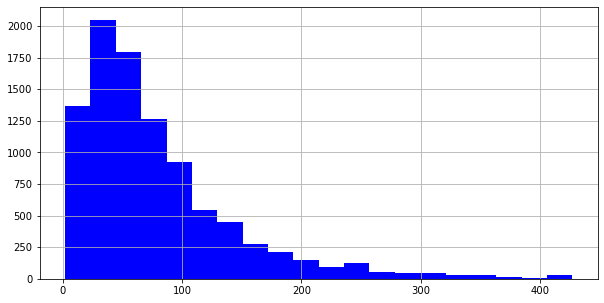

In [270]:
df['status_length'].hist(bins=20, color='blue', figsize=[10,5])

---

## EDA of Personality Scores

There are two sets of personality columns in the dataset: class and score. According to the attached paper, scores have been converted to categories based on whether a score for a user fell above or below the median.

### Plot the distributions of personality scores for all five score columns:

In [271]:
# Check the missed values with Dtype of the selected feature
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9513 entries, 0 to 9512
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   #AUTHID            9513 non-null   object 
 1   STATUS             9513 non-null   object 
 2   sEXT               9513 non-null   float64
 3   sNEU               9513 non-null   float64
 4   sAGR               9513 non-null   float64
 5   sCON               9513 non-null   float64
 6   sOPN               9513 non-null   float64
 7   cEXT               9513 non-null   object 
 8   cNEU               9513 non-null   object 
 9   cAGR               9513 non-null   object 
 10  cCON               9513 non-null   object 
 11  cOPN               9513 non-null   object 
 12  DATE               9513 non-null   object 
 13  status_length      9513 non-null   int64  
 14  status_word_count  9513 non-null   int64  
dtypes: float64(5), int64(2), object(8)
memory usage: 1.1+ MB


In [272]:
#Selecting the class and score features
df_class_score = df[['sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN']]
df_class_score.head(2)

,sEXT,sNEU,sAGR,sCON,sOPN
0,2.65,3.0,3.15,3.25,4.4
1,2.65,3.0,3.15,3.25,4.4


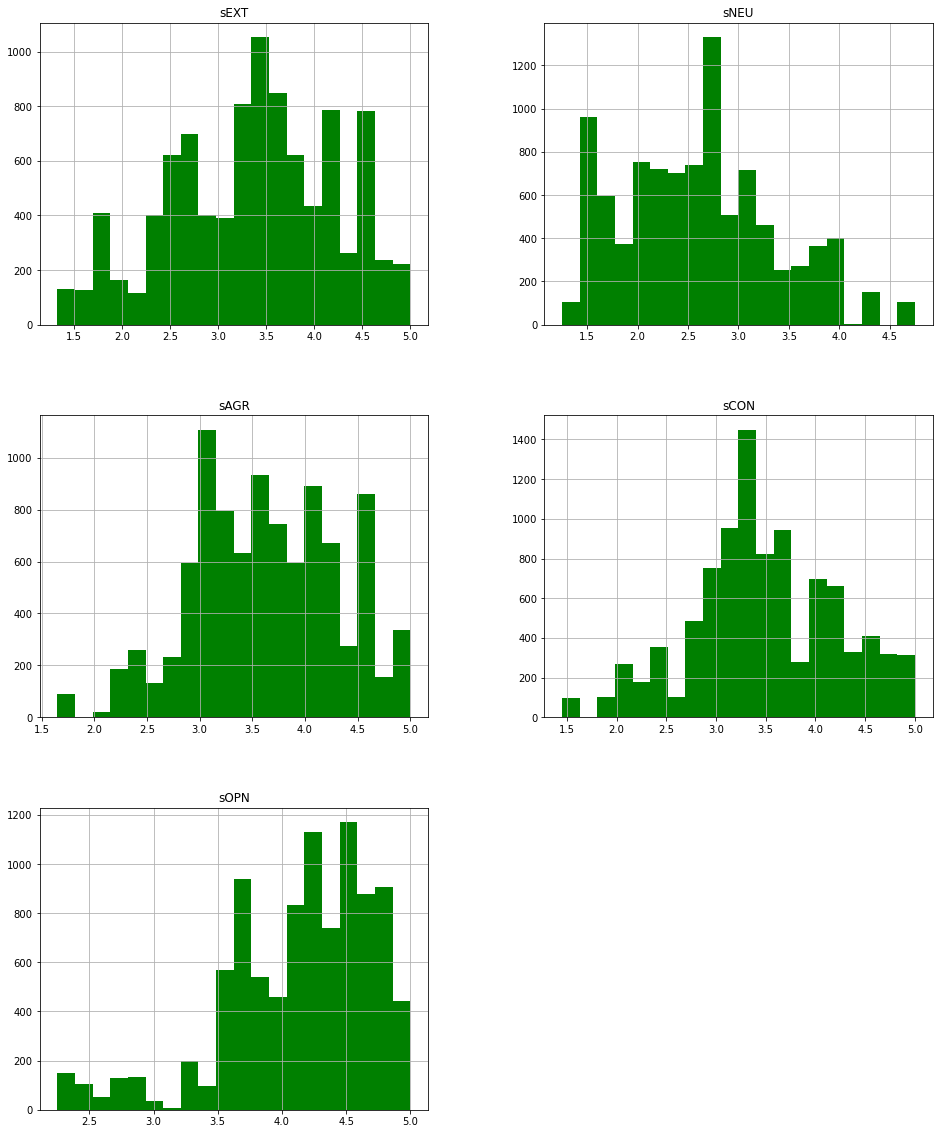

In [273]:
# Plot distribution of the class and score of the dataframe
df_class_score.hist(figsize=(16, 20), bins=20, color='green');

---

### How many unique users exist in the dataset?

This dataset has redacted original poster names, but each user is given an `#AUTHID`. How many unique users are there, and how many posts per user do we have?

In [274]:
len(df['#AUTHID'].unique())

250

In [275]:
df.head(1)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length,status_word_count
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,27,5


In [276]:
df['#AUTHID'].value_counts()

6f2bebc01062eb8334dccba3e048fdb5    219
e6cdef6f475cce3023c5b715f8c9f110    193
527ed53d2ba3a3bc417b8402d5b2f556    178
0737e4e4980f56c9fb1cb5743001c917    171
502db2fcfe26705ae16a46c5cb2ad2e5    161
                                   ... 
c255a1cb2939ce6b4719a8a0cc085624      1
a286b7286b1247d4a7851709e9f31e1e      1
69adae32cb076bf219e0d856ef233008      1
a764ca41dca158d7a191505dcc8ce47f      1
5532642937eb3497a43e15dbb23a9d2d      1
Name: #AUTHID, Length: 250, dtype: int64

In [277]:
countnum = 0
xx = []
for i in range(0, len(df['#AUTHID'])):
    
    if df['#AUTHID'][i] not in xx: 
        
        xx.append(df['#AUTHID'][i])
          
        countnum += 1
print("not unique values :",
      countnum)
  
print("unique values :",
      xx);

not unique values : 250
unique values : ['b7b7764cfa1c523e4e93ab2a79a946c4', '318bf822d4f2bd3920367560218619c0', 'ecbddbfe00e0f83cfdb802a7186061c7', 'db39f7b2aad360b1033ec1f8fcd57f9c', '4d035bd3fd8d9595d15cea9e388964be', '172400f46880b309ca5e97d322bb8f01', '200255966ca6e2636535b5b93ac04497', '5489ed38556af050d6a93e5d27b95dfb', 'b9a44bb356832160caccc9eb3614e0ce', '9a8cf1dcb2de1a8f70c4745a636bbb96', '527ed53d2ba3a3bc417b8402d5b2f556', '751e53fc64b770f7b5ea2b0964678599', 'c19a4fb5e846fb6575b0a8f3a2081ea0', 'e6cdef6f475cce3023c5b715f8c9f110', '2badb47503a98766c89e266d1130969a', '1c10cc0852579d2fa000e3fc3327bb98', '0737e4e4980f56c9fb1cb5743001c917', 'a6336ec5e11839ae33aee01fa2163652', '3d7847b1c33b5f5811208b4aa1a7ffbd', '83aeafc166238ebf5aaa2530e6205341', '2ea1efd66ffc011621a4a74e06005e23', '9b73d5a07c079cce614932e39e2f1852', 'd298a6d98000dc07bbb7994f71d867d3', '450c787001b004af69428e267c7a4ca1', 'd7f1da35557607089ee2e3a707ce4a4a', '4cac659f923d6f3b4605f38477a04458', 'c3f4b3e345cb6b032db2e0

## EDA on unique users

Because we have many posts per user for most users, doing EDA on the personality score columns might be misleading. If we have 200 Facebook statuses from one very high-conscientiousness user, a bar chart of how many `'cCON'` statuses are associated with `'y'` might be misleading. We'll have to be careful about labeling and titling any visualizations we make off of the dataset.

#### Create a new dataframe called `unique_users` that only contains the `#AUTHID`, personality score, and personality category columns:

If you do this correctly, it should have 250 rows and 11 columns.

(Hint: You can use the pandas [drop_duplicates()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html) method to make this easier. The only column you want to consider when deciding if a user is duplicated is the `#AUTHID` column.)

In [278]:
# Dropping all the duplicate values
yy = df.drop_duplicates(subset=['#AUTHID'])

In [280]:
yy.shape

(250, 15)

In [281]:
yy.columns

Index(['#AUTHID', 'STATUS', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cAGR', 'cCON', 'cOPN', 'DATE', 'status_length',
       'status_word_count'],
      dtype='object')

In [282]:
# creating unique_users dataframe
unique_users = yy[['#AUTHID','sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cAGR', 'cCON', 'cOPN',]]

In [283]:
unique_users.shape

(250, 11)

#### Plot the distribution of personality scores for `unique_users`:

Do the distributions look different? Here, each individual user will only be represented once.

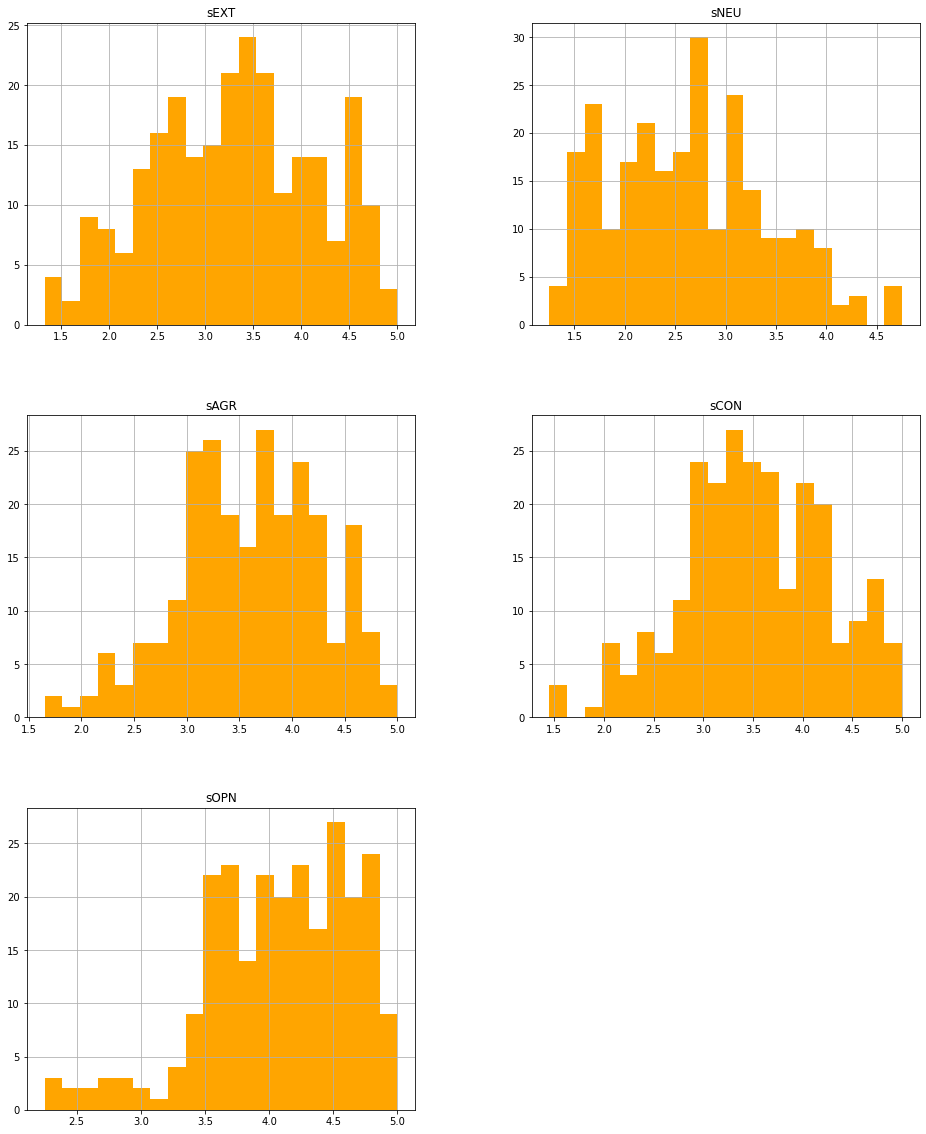

In [94]:
# Plot distribution of the class and score of the dataframe
unique_users.hist(figsize=(16, 20), bins=20, color='orange');

#### Use the `.describe()` method on `unique_users`:

In [284]:
unique_users.describe()

,sEXT,sNEU,sAGR,sCON,sOPN
count,250.000000,250.000000,250.000000,250.000000,250.00000
mean,3.292120,2.627240,3.600320,3.522920,4.07856
std,0.861368,0.776835,0.670758,0.740211,0.57506
min,1.330000,1.250000,1.650000,1.450000,2.25000
25%,2.662500,2.000000,3.150000,3.000000,3.75000
50%,3.300000,2.590000,3.660000,3.500000,4.15000
75%,4.000000,3.150000,4.100000,4.050000,4.50000
max,5.000000,4.750000,5.000000,5.000000,5.00000


### Plots vs. Tables

Consider what different information is easily conveyed by the plots of scores, versus the table with summary statistics. Explain when you might present a distribution versus when you might present a table of summary statistics.

In [285]:
# Generally, the distribution of the graphs and the descriptive table data are closer to each other. 
#Specifically, the table shows the max and min ranged not too far apart and the distribution variance values very narrow.

#### Other visualizations:

Create 1-2 additional visualizations related to the `unique_users` dataframe.

You might consider:
- Barcharts of users per category per trait
- A seaborn correlation heatmap
- A seaborn pairplot

<function matplotlib.pyplot.show(close=None, block=None)>

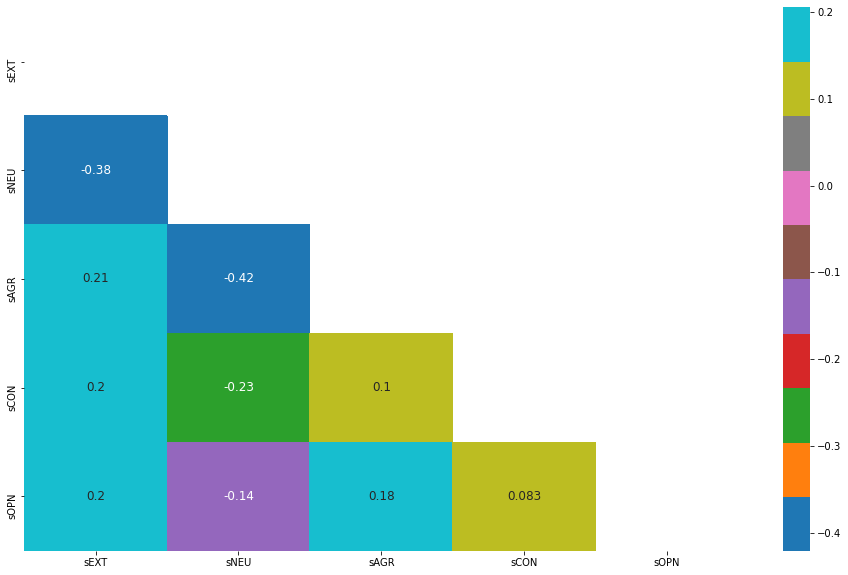

In [101]:
# Plot to see the corelation between features 
plt.figure(figsize=(16,10))
mask = np.zeros_like(unique_users.corr());
mask[np.triu_indices_from(mask)] = True; # hide the upper triangle of the graph
sns.heatmap(unique_users.corr(), annot=True, mask=mask, annot_kws={'size': 12}, cmap="tab10")
plt.show

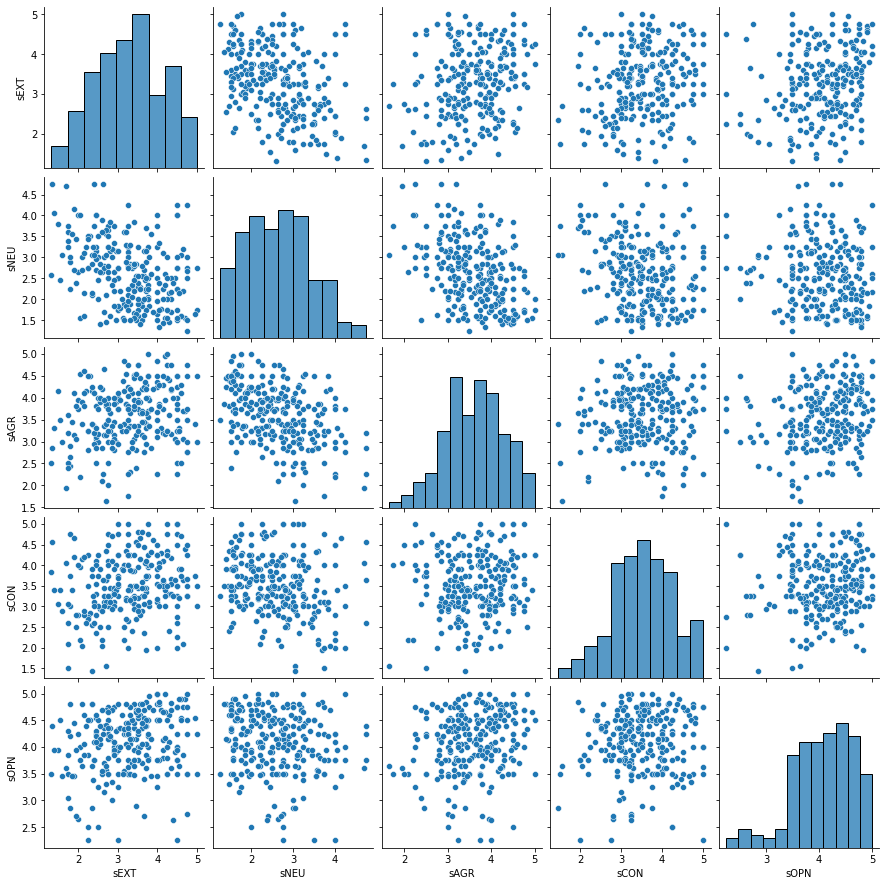

In [102]:
# Pair plot to visualize the data
sns.pairplot(unique_users);

---

## Exploring status length and word count based on personality

#### Using `groupby()`, find the mean status length and status word count for posts by users in the high and low categories of each of the Big 5 traits.

You'll need to use `groupby()` five separate times for this.

In [288]:
# Mean of status length
bb = df.groupby('status_length').mean()[['status_word_count']]
bb.head()

,status_word_count
status_length,
2,1.000000
3,1.090909
4,1.000000
5,1.062500
6,1.117647


In [119]:
# Sort descending the groupdby features of status length and word count
df.groupby(['status_length'])['status_word_count'].sum().sort_values(ascending=False).head()

status_length
255    1345
59     1025
63      979
52      977
54      946
Name: status_word_count, dtype: int64

In [121]:
# Sort ascending the groupdby features of status length and word count
df.groupby(['status_length'])['status_word_count'].sum().sort_values(ascending=True).head()

status_length
2     6
3    12
6    19
4    22
5    34
Name: status_word_count, dtype: int64

In [122]:
# Sort descending the groupdby features of status length and word count
df.groupby(['status_word_count'])['status_length'].sum().sort_values(ascending=False).head()

status_word_count
10    27425
12    26554
11    25904
8     25011
14    24959
Name: status_length, dtype: int64

In [123]:
# Sort ascending the groupdby features of status length and word count
df.groupby(['status_word_count'])['status_length'].sum().sort_values(ascending=True).head()

status_word_count
72    341
60    343
89    413
68    413
79    419
Name: status_length, dtype: int64

#### Choose one of the personality category columns (i.e. `cOPN`, `cCON`, `cEXT`, `cAGR`, or `cNEU`.) Use `sns.distplot()` to visualize the distribution of status word counts of posts by users who score high (`y`) and the distribution of status word counts of posts by users who score low (`n`) in that personality category:

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sOPN'>

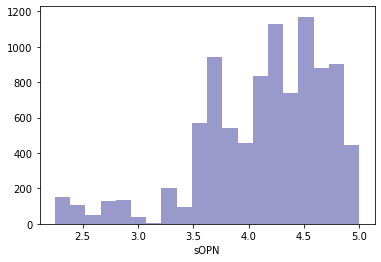

In [139]:
# Display plot to visualize how the data distributed
sns.distplot(df['sOPN'], kde = False, color ='navy', bins = 20);

---

## EDA on Word Counts

### Vectorize the text

In order to perform EDA on word count data, we'll need to count-vectorize.

Create a dataframe that contains the count-vectorized text for each Facebook status in the dataset.

To do this, you might follow these steps:
- Instantiate a `CountVectorizer` object
- Fit the count vectorizer on the Facebook statuses
- Store the transformed data
- Convert to a dataframe and store
    - Don't forget that the transformed data will need to be 'densified'. The `toarray()` or `todense()` methods will allow this.
    - Don't forget that the `get_feature_names()` method on a fitted `CountVectorizer` object will bring you back the words learned from the dataset, which you can set as the `columns` argument when creating the dataframe.
    
It's up to you whether or not to keep stopwords in the dataset.

In [289]:
# Instantiate CountVectorizer
cv = CountVectorizer()

# Fit the Facebook statuses with CountVectorizer
status = cv.fit(df['STATUS'])

# Use vocabulary_ attribute to show number words in feature 
print('The number of words is ',len(word_status.vocabulary_))

The number of words is  14949


### Show the 15 most common words

In [290]:
# Creat a fuction used as a whole cleaning processes
stop_words = stopwords.words('english') # defining stop_words
stop_words.remove('not')                # removing 'not' 

lemmatizer = WordNetLemmatizer()

def preprocessing(rev):
    # data cleaning
    review = re.sub(re.compile('<.*?>'), '', rev)  # removing tags and special characters
    review = re.sub('[^A-Za-z0-9]+', ' ', rev)      # taking only words

    # lowercase
    review = rev.lower()

    # tokenization
    tokens = word_tokenize(rev)

    # stop words removal
    rev = [word for word in tokens if word not in stop_words]

    # lemmatization
    rev = [lemmatizer.lemmatize(word) for word in rev]

    # join words in preprocessed review
    rev = ' '.join(rev)

    return rev

In [291]:
# Use data_preprocessing function to remove the stop words
df['status_clean'] = df['STATUS'].apply(lambda STATUS: preprocessing(STATUS))

In [294]:
# Check if it cleaned or not
df['STATUS'][0]

'likes the sound of thunder.'

In [295]:
# Check if it cleaned 
df['status_clean'][0]

'like sound thunder .'

In [296]:
# Fit the cleaned news with CountVectorizer
status_cleaned = cv.fit(df['status_clean'])

# Use vocabulary_ attribute to show cleaned words number in feature
print(f'The number of words after cleaning {len(status_cleaned.vocabulary_)}\nRelatively smaller than uncleaned one')

The number of words after cleaning 14028
Relatively smaller than uncleaned one


In [297]:
status_t = status_cleaned.transform(df['status_clean'])

# Define dataframe that contains the frequent words 
count_vect_df = pd.DataFrame(status_t.todense(), columns=status_cleaned.get_feature_names())

In [298]:
# Define dataframe that contains the sum of words 
sum_df = pd.DataFrame(np.sum(status_t.todense(),axis=0), columns=cv.get_feature_names())

# Sort the first 15 common words
sum_df.sort_values(by=0, ascending=False, axis=1).iloc[:,:15]

,propname,not,day,like,get,time,one,go,going,today,work,back,new,love,the
0,1247,694,645,478,473,466,454,425,392,389,378,377,374,350,346


### Show the 15 frequency of the most common words as a bar chart

**Hint**: You can do this in one line of code. [This webpage](https://dfrieds.com/data-visualizations/bar-plot-python-pandas.html) has an example.

In [368]:
#15 frequency of the most common words
common_word = sum_df.sort_values(by=0, ascending=False, axis=1).iloc[:,:15]
common_word

,propname,not,day,like,get,time,one,go,going,today,work,back,new,love,the
0,1247,694,645,478,473,466,454,425,392,389,378,377,374,350,346


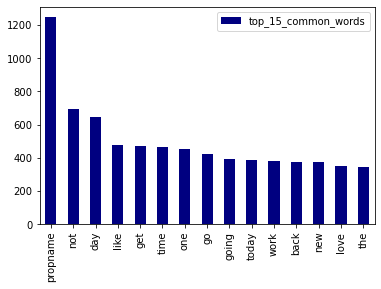

In [372]:
# Transpose the most common 15 words to make bar graph
yy=common_word.T
yy.columns=['top_15_common_words']
yy.plot(kind='bar',color='navy');


### Investigating `propname`

The word `propname` shows up frequently in this dataset. Show the first 10 statuses in the dataset that contain `propname`:

In [225]:
#Before cleaning the word propname existing upper case with *
df['STATUS'][6]

'saw a nun zombie, and liked it. Also, *PROPNAME* + Tentacle!Man + Psychic Powers = GREAT Party.'

In [222]:
# Cleanded words including propname
df[df['status_clean'].str.contains('propname')]['status_clean'].head(10)

6                                                                                                                                                                                saw nun zombie liked also propname tentacle man psychic power great party
18                                                                                                                                                                                                                        tired propname let go sleep pl0x
69                                                                                                                                                                fair idea manage 2 5 kid cliche need strong gentleman named propname thriteen wet napkin
100                                                                                                                                                                                                                               serious crush propnam

#### Provide a short explanation of what you believe `propname` to be:

Hint: The attached PDF also contains an explanation.

Answer: This is the proper name of a person has been replaced with a ﬁxed string (
*PROPNAME*).

## Most common words based on personality category

In order to do more targeted EDA, we'll need to be able to reference not only the dataframe of vectorized statuses, but also the personality scores from the original dataframe.

#### Create a new dataframe called `text_and_scores` that concatenates the count-vectorized statuses side-by-side with the original personality category columns:

In [242]:
# Creating of dataframe with given features
text_and_scores = df[['sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT', 'cNEU' ,'cAGR', 'cCON', 'cOPN','status_clean']]
text_and_scores.head(2)

,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,status_clean
0,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,like sound thunder
1,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,sleepy not even funny get sleep


In [237]:
df.head(1)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length,status_word_count,status_clean
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,27,5,like sound thunder


#### Show the 25 most common words for statuses from high-cAGR users:

In [248]:
# The most common 25 words from high-cAGR users 
text_and_scores.groupby(['status_clean'])['cAGR'].sum().sort_values(ascending=True).head(25)

status_clean
tenker p norge                                                                                                                                                                                                                                              n
ted nugent touch scary may intersting choice michigan politics                                                                                                                                                                                              n
techno colored beat                                                                                                                                                                                                                                         n
technical difficulty please standby                                                                                                                                                                                              

#### Show the 25 most common words for statuses from low-cAGR users:

In [247]:
# The most common 25 words from low-cAGR users 
text_and_scores.groupby(['status_clean'])['cAGR'].sum().sort_values(ascending=False).head(25)

status_clean
merry christmas everyone                                                                                                                                           yyynyn
great day                                                                                                                                                             yyy
dat                                                                                                                                                                   yyy
happy new year                                                                                                                                                    yynnnny
help smile                                                                                                                                                             yy
goooo tarheel                                                                                                                            

In [253]:
#Check there is any duplicate in the ID
df['#AUTHID'].duplicated()

0       False
1        True
2        True
3        True
4        True
        ...  
9508     True
9509    False
9510     True
9511    False
9512    False
Name: #AUTHID, Length: 9513, dtype: bool

In [373]:
# Description of the new dataframe
text_and_scores.describe()

,sEXT,sNEU,sAGR,sCON,sOPN
count,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000
mean,3.359269,2.598739,3.624913,3.484926,4.134251
std,0.856466,0.757319,0.681208,0.734690,0.584247
min,1.330000,1.250000,1.650000,1.450000,2.250000
25%,2.750000,2.000000,3.140000,3.050000,3.750000
50%,3.400000,2.550000,3.650000,3.450000,4.250000
75%,4.000000,3.050000,4.150000,4.000000,4.550000
max,5.000000,4.750000,5.000000,5.000000,5.000000


---

## Choose your own adventure

By now you've looked at a lot of visualizations and frequency counts.

Come up with 2-3 questions about the data, and try to answer them using descriptive statistics (like counts, averages, etc.) or visualizations.

Some questions you might explore:
- Have numbers been redacted, or are phone numbers, house numbers, or zip codes anywhere in the dataset?

Answer:  Yes, there are redacted in the data that is why the lenght of the data decreased after cleaning.


- Is _average_ word count per status related to any personality category or personality metric?

Answer: It is related to personality metric as shown in the frequency of word counts.


- Is punctuation use related to personality?

Answer: Yes, the social media personality feature created with linguistic features nd social features. 

- `PROPNAME` has been used to redact personal names. Given that this data was scraped between 2009 and 2011, investigate if any public figures or famous people show up in the dataset, or their names have been redacted as well.

Answer:
Yes, “Chopin” and “Mozart”, and locations, such as “New York” and “Mexico”, have not been replaced.

In [249]:
text_and_scores.describe()

,sEXT,sNEU,sAGR,sCON,sOPN
count,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000
mean,3.359269,2.598739,3.624913,3.484926,4.134251
std,0.856466,0.757319,0.681208,0.734690,0.584247
min,1.330000,1.250000,1.650000,1.450000,2.250000
25%,2.750000,2.000000,3.140000,3.050000,3.750000
50%,3.400000,2.550000,3.650000,3.450000,4.250000
75%,4.000000,3.050000,4.150000,4.000000,4.550000
max,5.000000,4.750000,5.000000,5.000000,5.000000


---

## Exploratory vs. Explanatory Data Analysis 

> **Exploratory analysis** is what you do to get familiar with the data. You may start out with a hypothesis or question, or you may just really be delving into the data to determine what might be interesting about it. Exploratory analysis is the process of turning over 100 rocks to find perhaps 1 or 2 precious gemstones.
>
> **Explanatory analysis** is what happens when you have something specific you want to show an audience - probably about those 1 or 2 precious gemstones. In my blogging and writing, I tend to focus mostly on this latter piece, explanatory analysis, when you've already gone through the exploratory analysis and from this have determined something specific you want to communicate to a given audience: in other words, when you want to tell a story with data.

- Cole Nussbaumer Knaflic, [exploratory vs. explanatory analysis](http://www.storytellingwithdata.com/blog/2014/04/exploratory-vs-explanatory-analysis)

### Choose one visual to explain:

Now that you've performed an exploratory data analysis, choose a visual (or 1-3 related visuals) to frame as _explanatory_. This can be a visual you created above, or you can create a new visual. For this visual, make sure the visuals are formatted clearly, and provide a one to two paragraph explanation/interpretation of the visual.

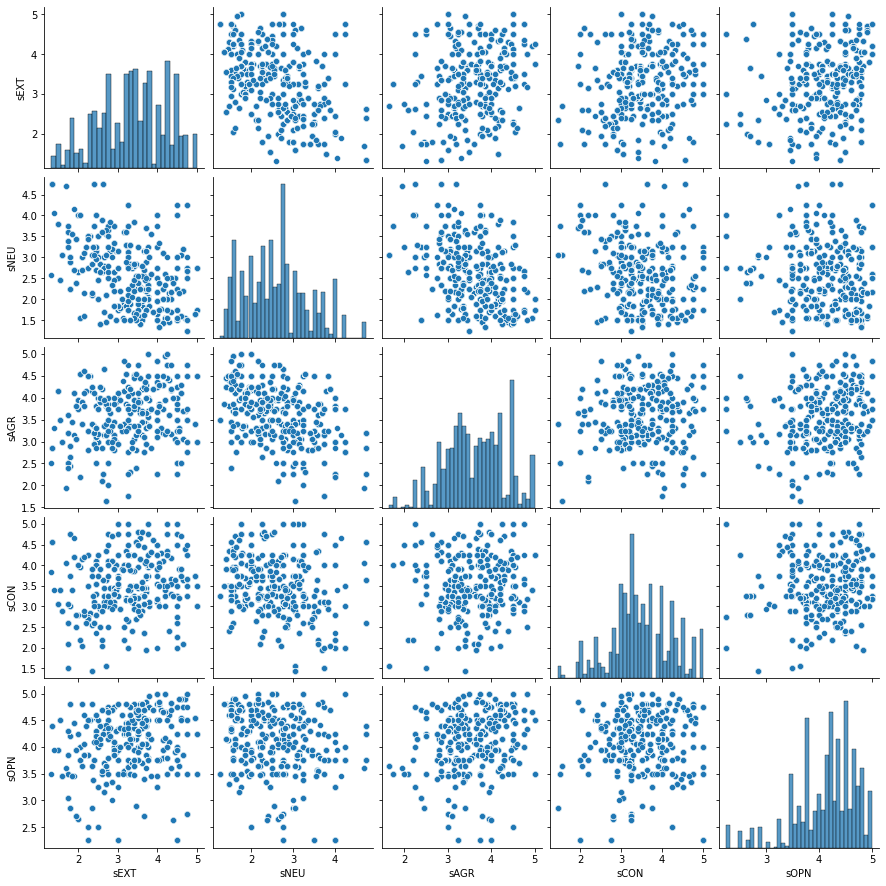

In [386]:
# Pair plot to visualize the cleaned data
sns.pairplot(text_and_scores);